#  Electricity Price Forecasting – Comparative Modeling Project

**Project Goal:** Develop and compare statistical, machine learning, and deep learning models to forecast hourly electricity prices one-step ahead and 24-steps ahead. 

**Dataset Period:** 2015–2018 (4 years of hourly electricity prices, energy generation, and weather data)

**Methodology:** CRISP-DM (Cross-Industry Standard Process for Data Mining)

---

## 1. Business Understanding

### 1.1 Business Objectives
Electricity is a critical resource for modern societies, and its price directly affects consumers, producers, and energy market participants. With the liberalization of electricity markets, prices fluctuate on an hourly basis depending on supply, demand, weather conditions, and generation sources. These fluctuations introduce uncertainty for grid operators, energy traders, and policy makers, making accurate price forecasting an essential task.

The objective of this project is to develop and compare different forecasting models capable of predicting electricity prices one hour ahead and one day ahead (24 hours). By leveraging historical electricity prices together with exogenous variables related to energy generation and weather conditions, the models aim to capture both short-term dynamics and daily seasonal patterns. Accurate forecasts can support better decision-making in energy trading, grid management, and operational planning, ultimately contributing to market efficiency and system stability.

### 1.2 Project Goals and Successs Criteria
From a data mining perspective, this problem is formulated as a time-series regression task, where the target variable is the electricity price at future time steps. The models are trained using four years of hourly data (2015–2018), with the final 12 months reserved as an out-of-sample test set to realistically evaluate forecasting performance.

The main goal of the project is not only to produce accurate forecasts, but also to compare different modelling paradigms, including statistical models, machine learning models, and deep learning models, under the same experimental setup. This comparative analysis allows us to assess the trade-offs between accuracy, stability, complexity, and interpretability.

Model performance is evaluated using standard regression error metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE). Additionally, all models are compared against a Seasonal Naïve baseline to ensure that improvements are meaningful and not trivial.

The success criteria for this project are defined as follows:
- Achieving a clear improvement over the Seasonal Naïve baseline for both 1-step and 24-step forecasts
- Maintaining stable performance across time-series cross-validation folds
- Producing forecasts that follow the main temporal patterns and seasonality of electricity prices
- Balancing predictive performance with computational efficiency, especially for multi-step forecasting
- Ensuring that the selected model is practical and interpretable enough to be used in real-world energy forecasting scenarios

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone
from sklearn.svm import SVR
from sklearn.ensemble import (
    BaggingRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from statsmodels.nonparametric.smoothers_lowess import lowess


---
## 2. Data Understanding

### 2.1 Data Collection

The first step is to load the datasets into the working environment. This involves importing the necessary libraries and reading the data file into a suitable data structure, namely, a DataFrame using Pandas.

In [45]:
# Load datasets
weather = pd.read_csv("weather.csv", parse_dates=["time"])
energy = pd.read_csv("energy_dataset.csv", parse_dates=["time"])

# Set 'time' as index
weather = weather.set_index("time")
energy = energy.set_index("time")

### 2.2 Data Description

##### Basic dataset information

In [46]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           35045 non-null  float64
 1   generation_fossil_brown_coal_lignite         35046 non-null  float64
 2   generation_fossil_coal-derived_gas           35046 non-null  float64
 3   generation_fossil_gas                        35046 non-null  float64
 4   generation_fossil_hard_coal                  35046 non-null  float64
 5   generation_fossil_oil                        35045 non-null  float64
 6   generation_fossil_oil_shale                  35046 non-null  float64
 7   generation_fossil_peat                       35046 non-null  float64
 8   generation_geothermal                        35046 non-null  float64
 9   generation_hydro_pumped_storage_a

The *energy* dataset contains 35064 entries and 24 features, representing hourly records of electricity generation from various sources, total system load, and the day-ahead market price. Each row corresponds to one hour of energy system operation, and the goal is to forecast the electricity price one hour and one day ahead.

In [47]:
energy.describe()

,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_coal-derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_aggregated,...,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_offshore,generation_wind_onshore,forecast_wind_offshore_eday_ahead,total_load_actual,price_day_ahead
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,...,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,0.0,35028.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,...,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,NaN,28696.939905,49.874341
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,...,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,NaN,4574.987950,14.618900
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,18041.000000,2.060000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,...,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,NaN,24807.750000,41.490000
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,...,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,NaN,28901.000000,50.520000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,...,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,NaN,32192.000000,60.530000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,...,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,NaN,41015.000000,101.990000


In [48]:
energy.head()

,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_coal-derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_aggregated,...,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_offshore,generation_wind_onshore,forecast_wind_offshore_eday_ahead,total_load_actual,price_day_ahead
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,NaN,25385.0,50.10
2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,NaN,24382.0,48.10
2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,NaN,22734.0,47.33
2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,NaN,21286.0,42.27
2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,NaN,20264.0,38.41


In [49]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  35064 non-null  float64
 1   pressure     35064 non-null  float64
 2   humidity     35064 non-null  float64
 3   wind_speed   35064 non-null  float64
dtypes: float64(4)
memory usage: 1.3+ MB


The *weather* dataset also contains 35064 entries and 5 features representing hourly meteorological measurements such as temperature, pressure, humidity, and wind speed. Each row corresponds to one hour of weather conditions, and these variables are used as exogenous inputs to improve electricity price forecasting.

In [50]:
weather.describe()

,temperature,pressure,humidity,wind_speed
count,35064.000000,35064.000000,35064.000000,35064.000000
mean,289.706862,1017.297872,68.033025,2.442944
std,7.251796,6.363845,14.814871,1.276415
min,272.006000,999.500000,22.600000,0.000000
25%,284.098877,1013.475000,56.750000,1.400000
50%,289.036200,1017.000000,69.600000,2.200000
75%,295.100500,1021.000000,80.000000,3.200000
max,309.048000,1035.500000,100.000000,8.500000


In [51]:
weather.head()

,temperature,pressure,humidity,wind_speed
time,,,,
2015-01-01 00:00:00+01:00,272.491463,1021.3,82.4,2.0
2015-01-01 01:00:00+01:00,272.512700,1021.2,82.4,2.0
2015-01-01 02:00:00+01:00,272.151937,1021.6,82.0,2.4
2015-01-01 03:00:00+01:00,272.142269,1021.5,82.0,2.4
2015-01-01 04:00:00+01:00,272.198700,1021.5,82.0,2.4


### 2.3 Data Exploration

#### 2.3.1 Target variable analysis

The target variable `price_day_ahead` represents the eletricity market price for the upcoming hour.

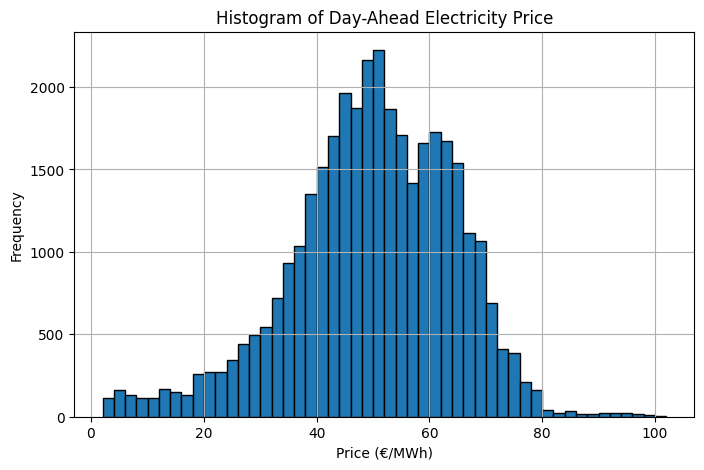

In [52]:
target_col='price_day_ahead'

plt.figure(figsize=(8,5))
plt.hist(energy[target_col], bins=50, edgecolor='black')
plt.title("Histogram of Day-Ahead Electricity Price")
plt.xlabel("Price (€/MWh)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The histogram shows a distribution that is very close to a normal distribution, although it is slightly right-skewed.

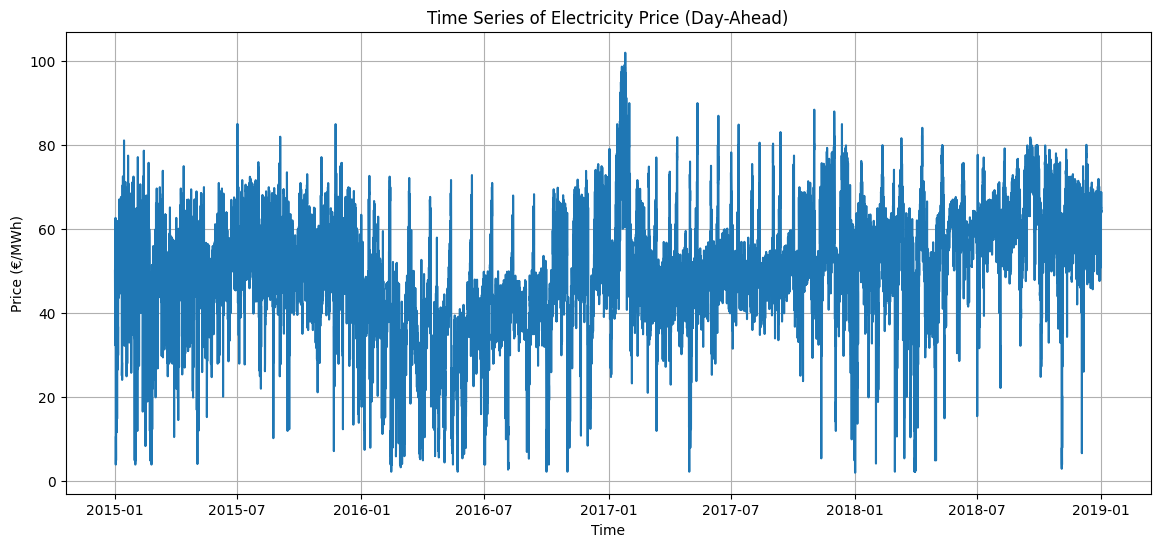

In [53]:
plt.figure(figsize=(14, 6))
plt.plot(energy[target_col])
plt.title("Time Series of Electricity Price (Day-Ahead)")
plt.xlabel("Time")
plt.ylabel("Price (€/MWh)")
plt.grid(True)
plt.show()

The time series plot shows strong short-term fluctuations and clear seasonal patterns, with occasional price spikes. Prices vary over time, indicating non-stationarity and the presence of both volatility and periodic behavior.

#### 2.3.2 Feature distribution analysis

Now we will perform feature distribution analysis to examine how the data values are spread across the datasets. We will use plots and histograms to visualise the distributions features. Box plots for will be skipped in this step, as they will be specifically used for outlier detection in paragraph `2.4.2`.

In [54]:
def feat_distribution(nonDiscreteFeatures, df):
    nrows = math.ceil(len(nonDiscreteFeatures) / 2)
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 5))
    axes = axes.flatten()

    for i, col in enumerate(nonDiscreteFeatures):
        df[col].hist(bins=30, ax=axes[i])
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    plt.show()

All of the features are numerical and continuous.

##### Energy dataset

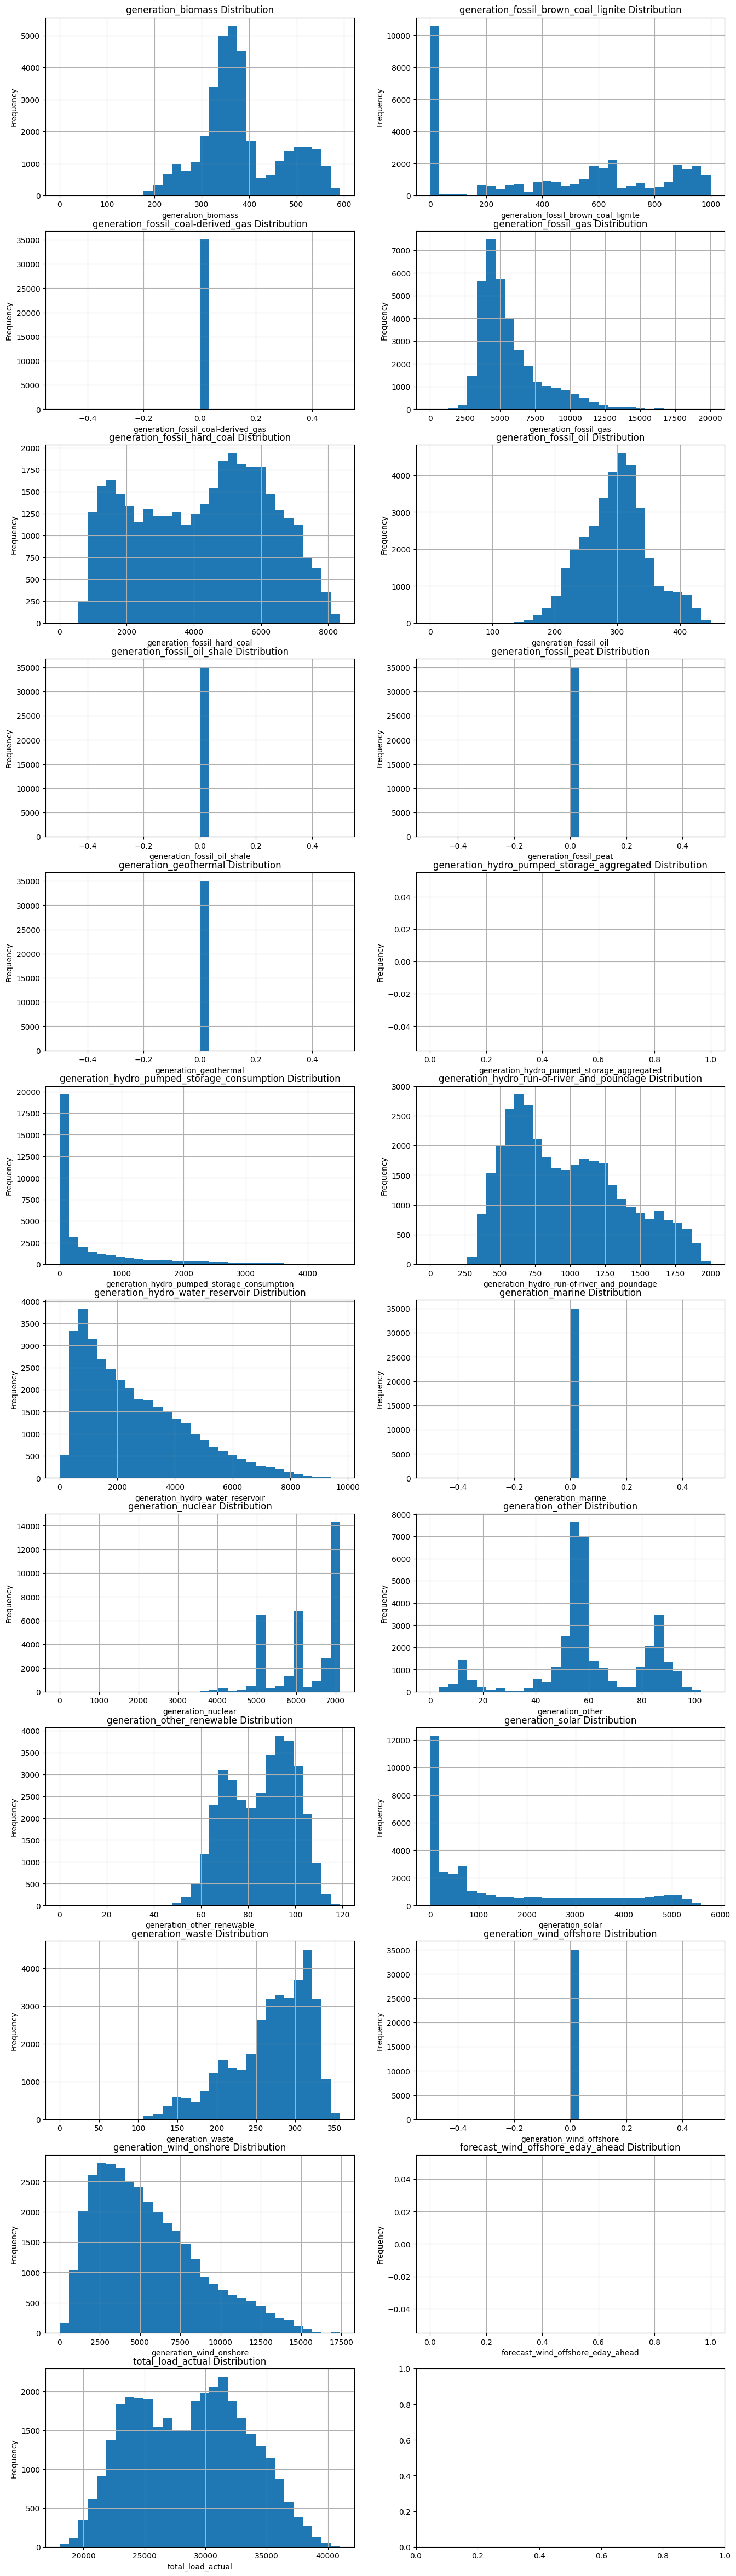

In [55]:
energy_features = [col for col in energy.columns 
                   if col not in ['time', 'price_day_ahead']]
feat_distribution(energy_features, energy)

None of the features has a normal distribution. `generation_hydro_pumped_storage_consumption`, `generation_hydro_water_reservoir`, and `generation_solar` are strongly right-skewed, while `generation_wind_onshore` is moderately right-skewed. In contrast, `generation_waste` is left-skewed.
Variables with skewed distributions will be handled in paragraph `3.4.3`, because skewness can negatively affect the models used later in paragraph `4.2`, particularly KNN, SVR, and Linear Regression, which rely on distance metrics or assumptions of linearity.

`generation_marine`, `generation_geothermal`, `generation_fossil_oil_shale`, `generation_fossil_peat`, and `generation_fossil_coal-derived_gas` contain only zeros, which is consistent with the dataset description provided in paragraph `2.2`.

The data represented by the remaining variables generally show irregular, multimodal, or heavily skewed shapes, reflecting the diverse and highly variable nature of electricity generation across different sources.

##### Weather dataset

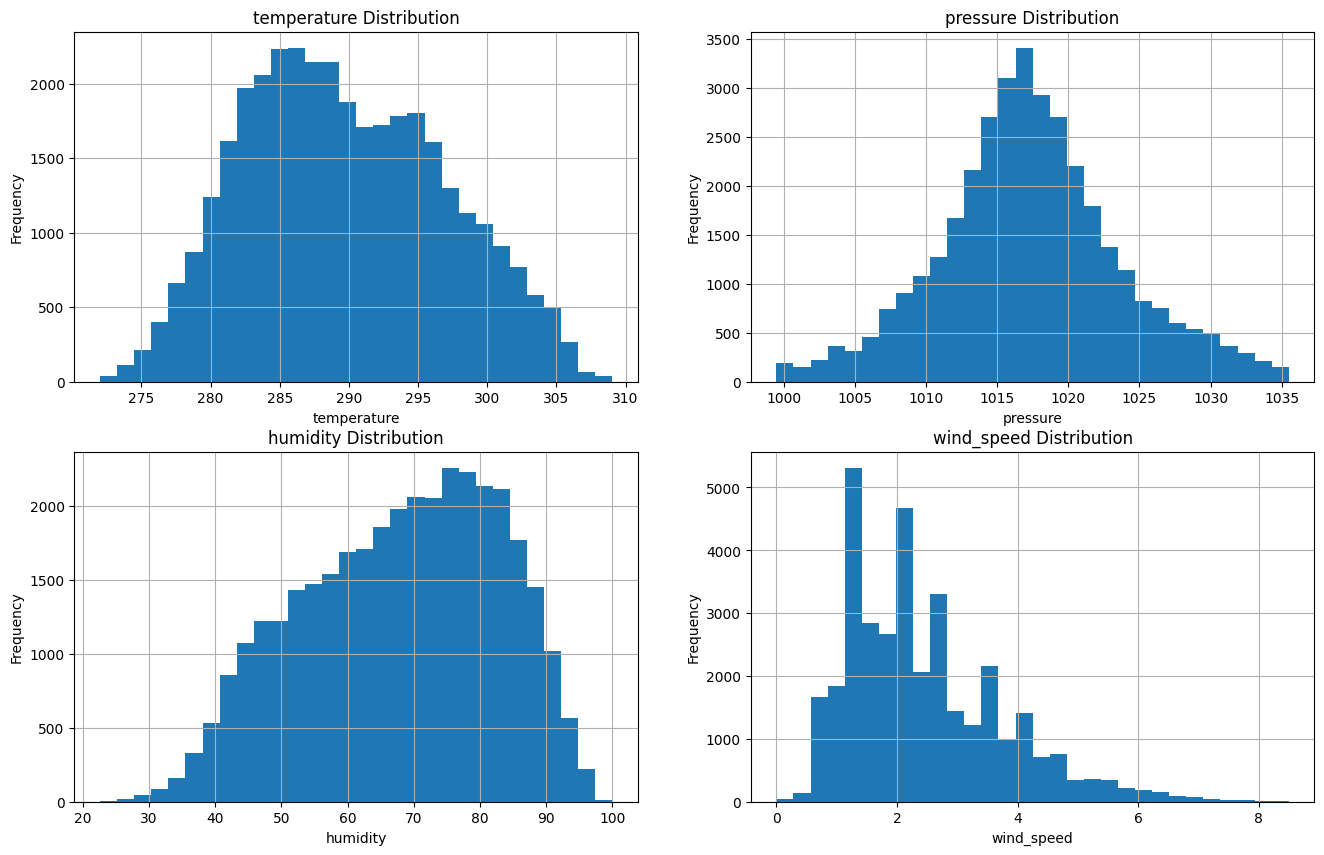

In [56]:
weather_features = [col for col in weather.columns if col != 'time']
feat_distribution(weather_features, weather)

`temperature` and `pressure` distribution is close to normal, whereas `humidity` is slightly left-skewed and `wind_speed` is right-skewed.

Skeweness will be handled in paragraph `3.3.1`.

In [57]:
skewed_cols = ['generation_hydro_pumped_storage_consumption','generation_hydro_water_reservoir','generation_solar','generation_wind_onshore','generation_waste','wind_speed']

### 2.4 Data Quality Assessment

#### 2.4.1 Identify missing values

In the first place, we will check for missing values to ensure data completeness and avoid potential issues during analysis and modeling.

In [58]:
# % missing values by column

def missing_values_info(df):
    nulls = df.isnull().sum()
    percent = round(nulls / df.shape[0] * 100, 3)
    
    nullvalues = pd.concat([nulls, percent], axis=1)
    nullvalues.columns = ["Count", "%"]
    
    return nullvalues


In [59]:
missing_values_info(energy)

,Count,%
generation_biomass,19,0.054
generation_fossil_brown_coal_lignite,18,0.051
generation_fossil_coal-derived_gas,18,0.051
generation_fossil_gas,18,0.051
generation_fossil_hard_coal,18,0.051
generation_fossil_oil,19,0.054
generation_fossil_oil_shale,18,0.051
generation_fossil_peat,18,0.051
generation_geothermal,18,0.051
generation_hydro_pumped_storage_aggregated,35064,100.000


The proportion of missing values varies across the energy-generation features. Most variables contain only a very small fraction of missing entries (around 0.05% each), including `generation_biomass`, `generation_fossil_gas`, `generation_solar`, `generation_wind_onshore`, and many others.
A few features have slightly higher but still low missing rates, such as `generation_nuclear` at 0.048% and `total_load_actual` at 0.103%.

Two variables — `generation_hydro_pumped_storage_aggregated` and `forecast_wind_offshore_eday_ahead` — have 100% missing values, meaning they contain no usable data.

In [60]:
# skipping the NaNs
energy_features = [
    f for f in energy_features
    if energy[f].notna().sum() > 0
]

In [61]:
missing_values_info(weather)

,Count,%
temperature,0,0.0
pressure,0,0.0
humidity,0,0.0
wind_speed,0,0.0


There are no missing values in `weather` dataset.

#### 2.4.2 Identify outliers

Based on dataframes information in paragraph `2.2` there might be potential outliers such as values at the extreme ends of the distributions (e.g., very high generation levels or unusually low/high prices). These points can disproportionately influence analysis and model results. That's why now we will identify outliers.



Rolling Window Analysis: calculate rolling mean and standard deviation. Values
that deviate significantly from the rolling mean (e.g., beyond ±3 standard
deviations) may be considered outliers


##### 2.4.2.1 Target variable

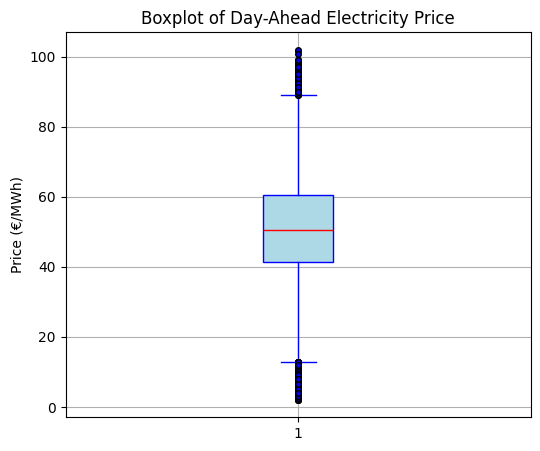

In [62]:
plt.figure(figsize=(6,5))
plt.boxplot(
    energy[target_col],
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    flierprops=dict(marker='o', markersize=4, markerfacecolor='blue')
)
plt.title("Boxplot of Day-Ahead Electricity Price")
plt.ylabel("Price (€/MWh)")
plt.grid(True)
plt.show()


The boxplot shows clear price spikes, confirming the presence of outliers in the target variable. These extreme values reflect real market volatility but may negatively affect several forecasting models. Therefore, while they are kept in the dataset, they will be handled later in paragraph `3.4.3` through appropriate preprocessing to minimise their impact on model performance.

##### 2.4.2.2 Energy features

In [63]:
def boxplots(numeric_features, df):
    num_plots = len(numeric_features)
    cols = 2
    rows = math.ceil(num_plots / cols)

    plt.figure(figsize=(cols * 5, rows * 4))

    for i, feature in enumerate(numeric_features):
        plt.subplot(rows, cols, i + 1)
        sns.boxplot(y=df[feature])
        plt.title(f"Boxplot: {feature}")

    plt.tight_layout()
    plt.show()

def outliers_detection(numericFeatures, df):
    Q1 = df[numericFeatures].quantile(0.25)
    Q3 = df[numericFeatures].quantile(0.75)
    IQR = Q3 - Q1

    outliers = ((df[numericFeatures] < (Q1 - 1.5 * IQR)) | (df[numericFeatures] > (Q3 + 1.5 * IQR)))
    print("Number of outliers per numeric feature:")
    print(outliers.sum())

    outliers_cols = outliers.any()
    outliers_cols = outliers_cols[outliers_cols].index.tolist()
    print("\nColumns containing outliers:")
    print(outliers_cols)


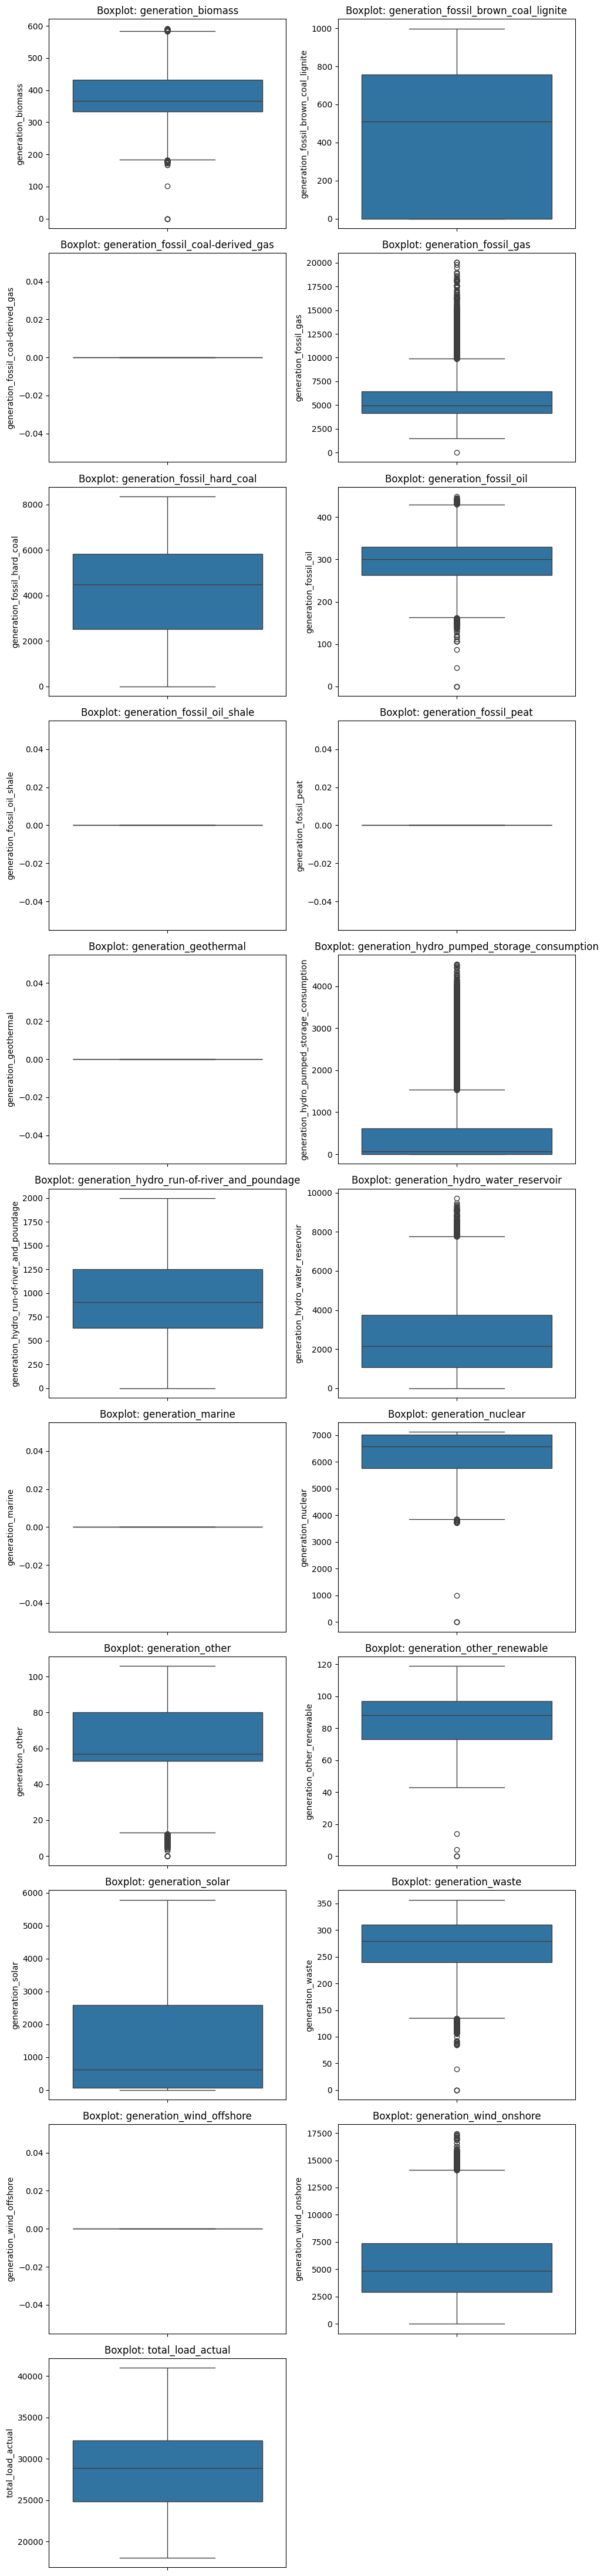

Number of outliers per numeric feature:
generation_biomass                               87
generation_fossil_brown_coal_lignite              0
generation_fossil_coal-derived_gas                0
generation_fossil_gas                          2185
generation_fossil_hard_coal                       0
generation_fossil_oil                           246
generation_fossil_oil_shale                       0
generation_fossil_peat                            0
generation_geothermal                             0
generation_hydro_pumped_storage_consumption    3762
generation_hydro_run-of-river_and_poundage        0
generation_hydro_water_reservoir                343
generation_marine                                 0
generation_nuclear                               74
generation_other                               1267
generation_other_renewable                        5
generation_solar                                  0
generation_waste                                328
generation_wind_offshore

In [64]:
boxplots(energy_features, energy)
outliers_detection(energy_features, energy)

We performed outliers detection on all numerical features using the Interquartile Range (IQR) method and visualized it using boxplots.

Features such as `generation_fossil_gas`, `generation_hydro_pumped_storage_consumption` and `generation_other` contain a high number of outlier values.
`generation_wind_onshore`, `generation_waste`,`generation_hydro_water_reservoir` and `generation_fossil_oil` also contained a noticeable number out outliers.
`generation_biomass` contains a few outliers.
The rest of the features of `energy` dataset showed no outliers according to the IQR method.

##### 2.4.2.3 Weather features

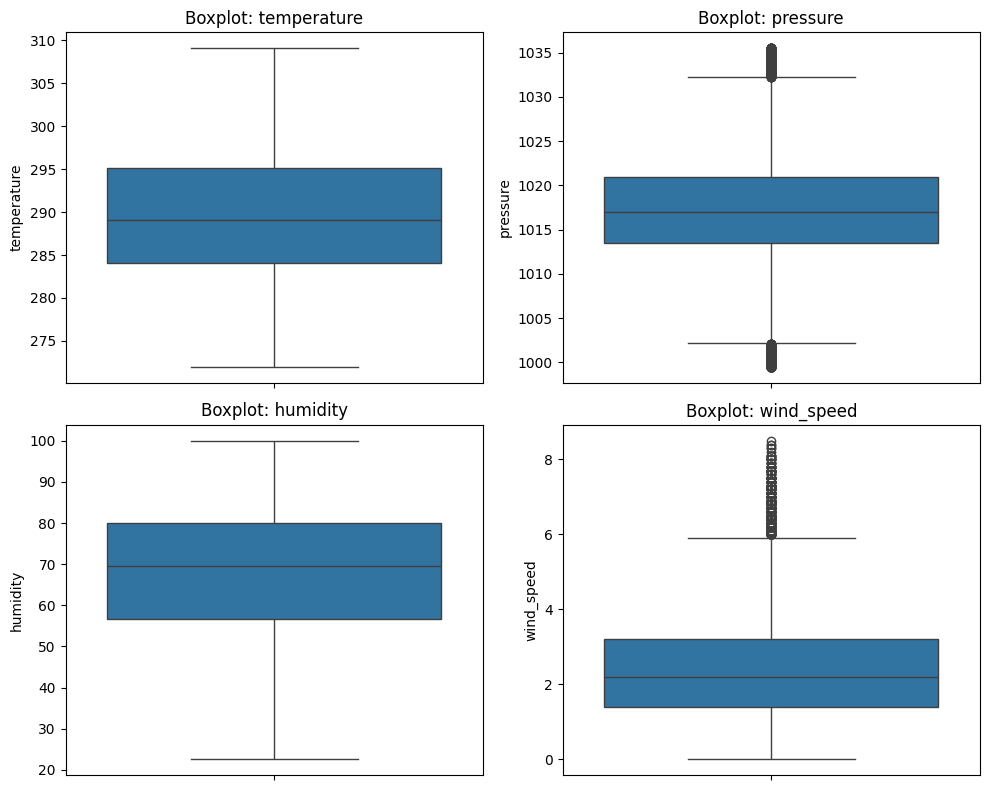

Number of outliers per numeric feature:
temperature      0
pressure       915
humidity         0
wind_speed     600
dtype: int64

Columns containing outliers:
['pressure', 'wind_speed']


In [65]:
boxplots(weather_features, weather)
outliers_detection(weather_features, weather)

`pressure` and `wind_speed` contain a noticeable number of outliers.

In [66]:
outliers_cols = ['pressure', 
                 'wind_speed', 
                 'generation_fossil_gas', 
                 'generation_hydro_pumped_storage_consumption', 
                 'generation_other', 
                 'generation_wind_onshore', 
                 'generation_waste',
                 'generation_hydro_water_reservoir',
                 'generation_biomass',
                 'generation_fossil_oil' ]

#### 2.4.3 Check data duplication

In [67]:
energy.index.duplicated().sum()


np.int64(0)

In [68]:
weather.index.duplicated().sum()

np.int64(0)

There are no duplicates.

---
## 3. Data Preparation

### 3.1 Data Cleaning

#### 3.1.1 Missing values

The first thing to be perfomed is to handle missing values indicated in paragraph `2.4.1`.

The missing values cannot be romoved that's why the NaNs will be filled in and columns only with NaNs will be dropped.

In [69]:
print("Remaining NaNs in energy:", energy.isna().sum().sum())

# Drop columns that contain only NaN values
energy = energy.dropna(axis=1, how='all')

# Interpolate missing values (time-series aware)
energy.index = pd.to_datetime(energy.index, errors='coerce', utc=True)
energy = energy.interpolate(method='time')

# Forward-fill remaining NaNs (edge cases)
energy = energy.ffill().bfill()

print("Remaining NaNs in energy:", energy.isna().sum().sum())


Remaining NaNs in energy: 70529
Remaining NaNs in energy: 0


#### 3.1.2 Handling outliers

To remove outliers identified in paragraph `2.4.2` we will perform winsorization and use **Robust Scaler** during `Data Transformation` in paragraph `3.3`.


### 3.2 Bivariate analysis

Here we will skip features that consist only of values 0.

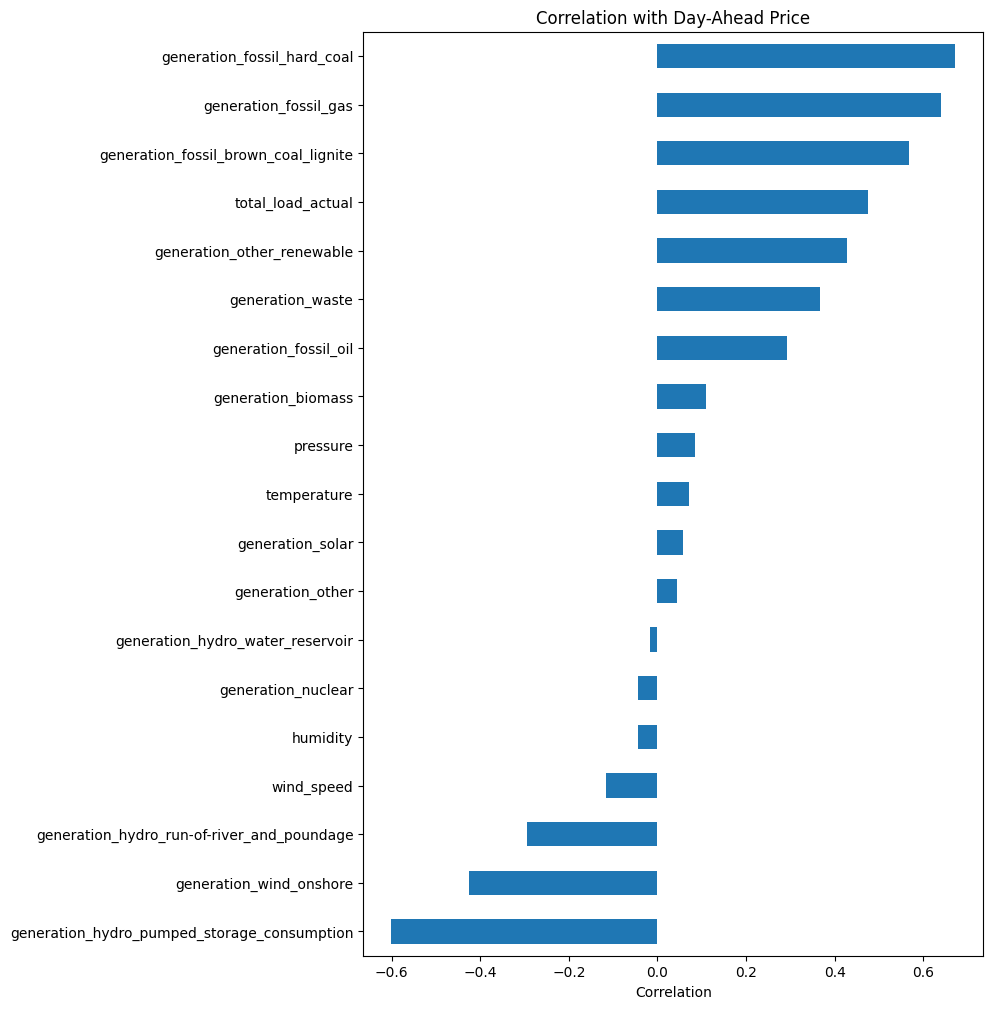

In [70]:
df_analysis = energy.join(weather, how="inner")

# remove columns that are entirely zero
non_zero_cols = df_analysis.columns[(df_analysis != 0).any()]

# keep only numeric features
num_df = df_analysis[non_zero_cols].select_dtypes(include="number")

# compute correlation with price
corr = num_df.corr()[target_col].drop(labels=[target_col]).sort_values()

plt.figure(figsize=(8,12))
corr.plot(kind="barh")
plt.title("Correlation with Day-Ahead Price")
plt.xlabel("Correlation")
plt.show()


The diagram shows that some variables are correlated positively, some nagetively and some are only slightly or not correlated with the target variable at all.

#### Correlation between the eletricity price and the day of the week

time
0    50.897537
1    51.313257
2    51.447382
3    51.178931
4    51.090010
5    47.505215
6    45.702356
Name: price_day_ahead, dtype: float64


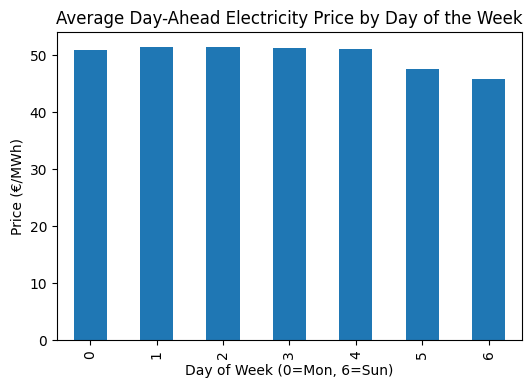

In [71]:
# print(type(energy.index))
# print(energy.index[:5])

weekday_price = energy['price_day_ahead'].groupby(energy.index.to_series().dt.dayofweek).mean()
print(weekday_price)

plt.figure(figsize=(6,4))
weekday_price.plot(kind='bar')
plt.title("Average Day-Ahead Electricity Price by Day of the Week")
plt.ylabel("Price (€/MWh)")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.show()


There's no strong dependency between the day of the week and the eletricity price, however the price tends to be lower on the weekends.

##### Correlation between the temperature and the eletricity price

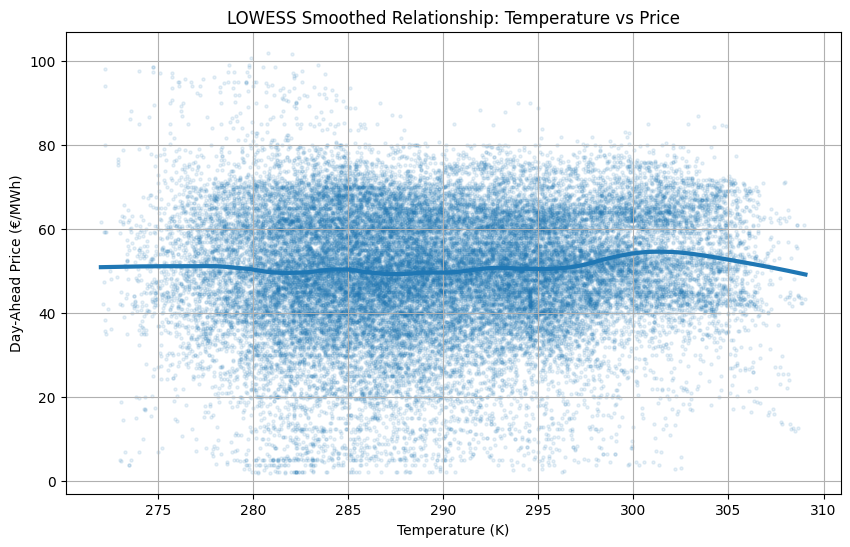

In [72]:
x = df_analysis["temperature"]
y = df_analysis[target_col]

# smooth curve
low = lowess(y, x, frac=0.15)

plt.figure(figsize=(10,6))
plt.scatter(x, y, s=5, alpha=0.1)
plt.plot(low[:,0], low[:,1], linewidth=3)

plt.title("LOWESS Smoothed Relationship: Temperature vs Price")
plt.xlabel("Temperature (K)")
plt.ylabel("Day-Ahead Price (€/MWh)")
plt.grid(True)
plt.show()


There's no significant correlation between the eletricity price and the temperature.

### 3.3 Data Transformation

Since all the features are numerical they don't have to be encoded in any way.

#### 3.3.1 Dropping unnecessary variables

There are variables with all 0 values. They will be dropped.

In [73]:
df = energy.join(weather, how="inner")

dfML = df.copy()

zero_cols = dfML.columns[(dfML == 0).all()]
print("Dropped columns with all zeros:", list(zero_cols))

dfML = dfML.drop(columns=zero_cols)

dfML.info()

Dropped columns with all zeros: ['generation_fossil_coal-derived_gas', 'generation_fossil_oil_shale', 'generation_fossil_peat', 'generation_geothermal', 'generation_marine', 'generation_wind_offshore']
<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           35064 non-null  float64
 1   generation_fossil_brown_coal_lignite         35064 non-null  float64
 2   generation_fossil_gas                        35064 non-null  float64
 3   generation_fossil_hard_coal                  35064 non-null  float64
 4   generation_fossil_oil                        35064 non-null  float64
 5   generation_hydro_pumped_storage_consumption  35064 non-null  float64
 6   generation_hydro_run-of-river_and_poundage   35064 no


#### 3.3.1 Handling variables with skewed distribution

Since not all of the skewed distrubutions concern variables with positive values we will use **Yeo-Johnson** scaler.

In [74]:
# Cast to float before transformation to avoid dtype issues
dfML = dfML.copy()

for col in skewed_cols:
    dfML[col] = dfML[col].astype(float)

In [75]:
pt = PowerTransformer(method='yeo-johnson')

print(df[skewed_cols].dtypes)

dfML.loc[:, skewed_cols] = pt.fit_transform(dfML.loc[:, skewed_cols])

generation_hydro_pumped_storage_consumption    float64
generation_hydro_water_reservoir               float64
generation_solar                               float64
generation_wind_onshore                        float64
generation_waste                               float64
wind_speed                                     float64
dtype: object


#### 3.3.2 Handling outliers

As indicated in paragraph `3.1`, we will use **Robust Scaler** to handle outliers.

In [76]:
# Feature scaling

# Initialize the scaler
scaler = RobustScaler()

print(outliers_cols)
print(type(outliers_cols))

# Fit the scaler on the numeric features and transform
dfML.loc[:,outliers_cols] = scaler.fit_transform(dfML[outliers_cols])

['pressure', 'wind_speed', 'generation_fossil_gas', 'generation_hydro_pumped_storage_consumption', 'generation_other', 'generation_wind_onshore', 'generation_waste', 'generation_hydro_water_reservoir', 'generation_biomass', 'generation_fossil_oil']
<class 'list'>


### 3.4 Data Splitting

To evaluate the models that will be used in paragraph `4` we have to split dataset into a train and a test set. We will use an 75/25 split ratio (the whole dataset represents 4 years of data and the test set will consist of last 12 months) to ensure sufficient amount of data for training while retaining enough samples for meaningful evaluation.

In [77]:
# Last 12 months for test
split_date = dfML.index.max() - pd.DateOffset(years=1)

train_dfML = dfML[dfML.index <= split_date]
test_dfML  = dfML[dfML.index > split_date]

print("Split date:", split_date)
print("Train:", train_dfML.shape)
print("Test:", test_dfML.shape)

Split date: 2017-12-31 22:00:00+00:00
Train: (26304, 20)
Test: (8760, 20)


### 3.5 Feature selection

#### Embedded method - Lasso regularization

In [78]:
def lasso_regularization(df, target_col="price_day_ahead"):

    X = df.drop(columns=[target_col]).copy()
    y = df[target_col].copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = Lasso(alpha=0.01, random_state=42, max_iter=5000)

    sel_ = SelectFromModel(lasso)
    sel_.fit(X_scaled, y)

    selected_feat = X.columns[sel_.get_support()]
    removed_feat = X.columns[~sel_.get_support()]

    print(f"Selected features ({len(selected_feat)}):")
    print(selected_feat.tolist())

    print(f"\nRemoved features ({len(removed_feat)}):")
    print(removed_feat.tolist())

    return selected_feat

In [79]:
Lasso_SelectedColumns = lasso_regularization(train_dfML)

Lasso_SelectedColumns

Selected features (19):
['generation_biomass', 'generation_fossil_brown_coal_lignite', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run-of-river_and_poundage', 'generation_hydro_water_reservoir', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_onshore', 'total_load_actual', 'temperature', 'pressure', 'humidity', 'wind_speed']

Removed features (0):
[]


Index(['generation_biomass', 'generation_fossil_brown_coal_lignite',
       'generation_fossil_gas', 'generation_fossil_hard_coal',
       'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption',
       'generation_hydro_run-of-river_and_poundage',
       'generation_hydro_water_reservoir', 'generation_nuclear',
       'generation_other', 'generation_other_renewable', 'generation_solar',
       'generation_waste', 'generation_wind_onshore', 'total_load_actual',
       'temperature', 'pressure', 'humidity', 'wind_speed'],
      dtype='object')

In [80]:
train_dfML = train_dfML[list(Lasso_SelectedColumns) + [target_col]]
test_dfML  = test_dfML[list(Lasso_SelectedColumns) + [target_col]]

:asso regularization removed DOK

We prepared dataframes for future testing and tuning to compare different models and select the one with the best performance.

---
## 4. Modelling

### 4.1 Statistical Models

TODO

### 4.2 Machine Learning Models

In this project, several machine learning regression models are trained and hyperparameter-tuned using time-series cross-validation to predict electricity prices. Their performance is then compared using error metrics in order to select the model that generalizes best for final forecasting.

#### 4.2.1 Build supervised sliding-window datasets

We will be using two functions two build sliding-window datasets. `make_sliding_window` is used for single-step predicitons and `slideWindow` for multi-step predictions. Later these functions will be used to build the sliding-window datasets after choosing the best window size in paragraph `4.2.2`.

In [81]:
def make_sliding_window(series, window_size, horizon=1): # for single-step
    X, y = [], []
    for i in range(len(series) - window_size - horizon + 1):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size + horizon - 1])
    return np.array(X), np.array(y)


def slideWindow(time_series, window_in, horizon): # for multi-step
    if (len(time_series) - window_in - horizon + 1) <= 0:
       raise ValueError("Time series too short for window size or horizon.")
    
    d = time_series.values
    X, y = [], []

    for start in range(len(time_series)-window_in):
        end = start + window_in
        out = end + horizon
        X.append(d[start:end].reshape(-1))
        y.append(d[end:out].ravel()) # ravel() is equivalent to reshape(-1): returnscontiguous flattened array
        cols_x = [f'x{i}' for i in range(1, window_in+1)]
        cols_y = [f'y{i}' for i in range(1, horizon+1)]
        df_X = pd.DataFrame(X, columns=cols_x)
        df_y = pd.DataFrame(y, columns=cols_y)

    return pd.concat([df_X, df_y], axis=1).dropna()

def slideWindow2(time_series, window_in, horizon): # improved performance
    if (len(time_series) - window_in - horizon + 1) <= 0:
        raise ValueError("Time series too short for window size or horizon.")

    d = time_series.values
    n_samples = len(d) - window_in - horizon + 1

    X = np.empty((n_samples, window_in))
    y = np.empty((n_samples, horizon))

    for i in range(n_samples):
        X[i] = d[i : i + window_in]
        y[i] = d[i + window_in : i + window_in + horizon]

    cols_x = [f"x{i}" for i in range(1, window_in + 1)]
    cols_y = [f"y{i}" for i in range(1, horizon + 1)]

    return pd.DataFrame(
        np.hstack([X, y]),
        columns=cols_x + cols_y
    )

#### 4.2.2 Several window sizes comparison

Now we will compare three window sizes (one day, two days and one week) to find the most efficient one. For that we will use Random Forest because it's the least sensitive to data changes and variance is reduced by averaging.
To compare the results we will use MAE - Mean Aboslute Error - because it has low sensitivity.

In [82]:
window_sizes = [24, 48, 168]   # 1 day, 2 days, 1 week
horizons = [1, 24] # the number of time steps into the future to forecast at any point in time

tscv = TimeSeriesSplit(n_splits=5)

results = []

for w in window_sizes:

    X, y = make_sliding_window(train_dfML[target_col].values, window_size=w, horizon=1)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = RandomForestRegressor(
            n_estimators=50,
            max_depth=10,
            random_state=42,
            n_jobs=-1 # enable paralelism
        )

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)

        results.append({
            "window": w,
            "fold": fold,
            "MAE": mae
        })
        print(f"Window {w}, Fold {fold}")

results_df = pd.DataFrame(results)
print(results_df.groupby("window")["MAE"].mean())


Window 24, Fold 0
Window 24, Fold 1
Window 24, Fold 2
Window 24, Fold 3
Window 24, Fold 4
Window 48, Fold 0
Window 48, Fold 1
Window 48, Fold 2
Window 48, Fold 3
Window 48, Fold 4
Window 168, Fold 0
Window 168, Fold 1
Window 168, Fold 2
Window 168, Fold 3
Window 168, Fold 4
window
24     2.249083
48     2.258433
168    2.316499
Name: MAE, dtype: float64


Mean Aboslute Error (MAE) is the lowest for 24-hour long window, which means that using the previous full day of information allows the model to make more accurate predictions on average

In [83]:
BEST_WINDOW = 24

In [84]:
X_train, y_train = make_sliding_window(
    train_dfML[target_col].values,
    window_size=BEST_WINDOW,
    horizon=1
)

print("One Day Sliding Window Created for 1 step for the training set") 

One Day Sliding Window Created for 1 step for the training set


In [85]:
X_test, y_test = make_sliding_window(
    test_dfML[target_col].values,
    window_size=BEST_WINDOW,
    horizon=1
)

print("One Day Sliding Window Created for 1 step for the testing set") 

One Day Sliding Window Created for 1 step for the testing set


In [86]:
df_sw_multi_step_train = slideWindow2(
        train_dfML[target_col],
        window_in=BEST_WINDOW,
        horizon=24
    )

print("One Day Sliding Window Created for 24 step for the training set") 

One Day Sliding Window Created for 24 step for the training set


In [87]:
df_sw_multi_step_test = slideWindow2(
        test_dfML[target_col],
        window_in=BEST_WINDOW,
        horizon=24
    )

print("One Day Sliding Window Created for 24 step for the testing set") 

One Day Sliding Window Created for 24 step for the testing set


#### 4.2.3 Model selection and tuning

Model selection is performed using 1-step ahead predictions, as this setting provides a fair and computationally efficient basis for comparing different algorithms. All models are trained on supervised sliding-window datasets and evaluated using time-series cross-validation, ensuring that temporal order is preserved and data leakage is avoided.

The following regression algorithms are considered: Linear Regression, Decision Tree Regressor, k-Nearest Neighbours (KNN), Support Vector Regression (SVR), Bagging Regressor, Gradient Boosting Regressor, Random Forest Regressor, XGBoost Regressor, and LightGBM Regressor. For models sensitive to feature scaling (Linear Regression, KNN, and SVR), a StandardScaler is included using a pipeline.

In [88]:
models_stage1 = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),

    "DecisionTree": DecisionTreeRegressor(random_state=42),

    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor())
    ]),

    "SVR": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVR())
    ]),

    "Bagging": BaggingRegressor(random_state=42),

    "GradientBoosting": GradientBoostingRegressor(random_state=42),

    "RandomForest": RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),

    "XGBoost": XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ),

    "LightGBM": LGBMRegressor(
        random_state=42
    )
}

In [89]:
def safe_mape(y_true, y_pred, eps=1e-8):
    y_true = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / y_true))


In [90]:
scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(
        lambda y, yhat: np.sqrt(mean_squared_error(y, yhat)),
        greater_is_better=False
    ),
    "mape": make_scorer(
        safe_mape,
        greater_is_better=False
    )
}

In [91]:
tscv = TimeSeriesSplit(n_splits=5)

stage1_results = []

feature_names = [f"x{i}" for i in range(1, X_train.shape[1] + 1)]

for name, model in models_stage1.items():
    fold_mae = []
    fold_rmse = []
    fold_mape = []

    print(f"\nTraining model: {name}")

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        print(f"  Fold {fold}/5")

        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model_fold = clone(model)

        if name == "LightGBM":
            X_tr = pd.DataFrame(X_tr, columns=feature_names)
            X_val = pd.DataFrame(X_val, columns=feature_names)

        model_fold.fit(X_tr, y_tr)
        y_pred = model_fold.predict(X_val)

        fold_mae.append(mean_absolute_error(y_val, y_pred))
        fold_rmse.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        fold_mape.append(
            np.mean(np.abs((y_val - y_pred) / np.maximum(np.abs(y_val), 1e-8)))
        )

    stage1_results.append({
        "Model": name,
        "MAE": np.mean(fold_mae),
        "RMSE": np.mean(fold_rmse),
        "MAPE": np.mean(fold_mape),
    })

    print(f"  → MAE:  {np.mean(fold_mae):.3f}")
    print(f"  → RMSE: {np.mean(fold_rmse):.3f}")
    print(f"  → MAPE: {np.mean(fold_mape):.3f}")



Training model: LinearRegression
  Fold 1/5


  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  → MAE:  2.027
  → RMSE: 3.119
  → MAPE: 0.056

Training model: DecisionTree
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  → MAE:  3.455
  → RMSE: 5.299
  → MAPE: 0.102

Training model: KNN
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  → MAE:  3.927
  → RMSE: 5.524
  → MAPE: 0.124

Training model: SVR
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  → MAE:  3.149
  → RMSE: 5.650
  → MAPE: 0.129

Training model: Bagging
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  → MAE:  2.382
  → RMSE: 3.659
  → MAPE: 0.068

Training model: GradientBoosting
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  → MAE:  2.332
  → RMSE: 3.632
  → MAPE: 0.069

Training model: RandomForest
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  → MAE:  2.218
  → RMSE: 3.482
  → MAPE: 0.066

Training model: XGBoost
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  → MAE:  2.436
  → RMSE: 3.772
  → MAPE: 0.077



In [92]:
results_stage1 = (
    pd.DataFrame(stage1_results)
      .sort_values(by=["MAE", "RMSE", "MAPE"])
      .reset_index(drop=True)
)

print("\nFinal results:")
print(results_stage1)



Final results:
              Model       MAE      RMSE      MAPE
0  LinearRegression  2.027226  3.119120  0.056081
1      RandomForest  2.217789  3.481925  0.065677
2          LightGBM  2.299236  3.589891  0.069324
3  GradientBoosting  2.331883  3.632150  0.068788
4           Bagging  2.382228  3.658807  0.067565
5           XGBoost  2.436203  3.772397  0.077259
6               SVR  3.148904  5.650184  0.129055
7      DecisionTree  3.455143  5.299461  0.102029
8               KNN  3.926630  5.523529  0.124120


Before tuning:

| Model            | MAE    | RMSE   | MAPE   |
| ---------------- | ------ | ------ | ------ |
| LinearRegression | 2.0272 | 3.1191 | 0.0561 |
| RandomForest     | 2.2178 | 3.4819 | 0.0657 |
| LightGBM         | 2.2992 | 3.5899 | 0.0693 |
| GradientBoosting | 2.3319 | 3.6322 | 0.0688 |
| Bagging          | 2.3822 | 3.6588 | 0.0676 |
| XGBoost          | 2.4362 | 3.7724 | 0.0773 |
| SVR              | 3.1489 | 5.6502 | 0.1291 |
| DecisionTree     | 3.4551 | 5.2995 | 0.1020 |
| KNN              | 3.9266 | 5.5235 | 0.1241 |


*Linear Regression* clearly outperforms all other models, achieving the lowest MAE, RMSE, and MAPE, which suggests that the electricity price dynamics are largely linear for 1-step-ahead forecasting. Ensemble tree-based models (Random Forest, Gradient Boosting, LightGBM) show competitive but slightly inferior performance, while instance-based and kernel methods (KNN, SVR) perform considerably worse, indicating limited benefit from more complex non-linear models at this stage.

#### 4.2.4 Hyperparameter tuning

Hyperparameter tuning is carried out using *TimeSeriesSplit*, optimizing the Mean Absolute Error (MAE) as the primary selection criterion. This metric is chosen due to its robustness and direct interpretability in the context of electricity price forecasting. For each model, the best-performing hyperparameter configuration is selected based on cross-validation results. 

Linear Regression will noe be tuned because it has no meaningful hyperparameters that control model complexity.

In [93]:
param_grids = {
    "DecisionTree": {
        "max_depth": [3, 5, 10, None],
        "min_samples_leaf": [1, 5, 10]
    },

    "KNN": {
        "model__n_neighbors": [3, 5, 10, 20]
    },

    "SVR": {
        "model__C": [1, 10],
        "model__gamma": ["scale"]
    },

    "Bagging": {
        "n_estimators": [50, 100]
    },

    "GradientBoosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5]
    },

    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [5, 10, None]
    },

    "XGBoost": {
        "n_estimators": [200, 400],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5]
    },

    "LightGBM": {
        "n_estimators": [200, 400],
        "learning_rate": [0.05, 0.1],
        "num_leaves": [31, 63]
    }
}


In [94]:
tuning_results = []
best_estimators = {}

tscv = TimeSeriesSplit(n_splits=5)

for name, model in models_stage1.items():
    print(f"\nTuning model: {name}")

    if name == "LinearRegression":
        print("No tuning perfomed")
        continue

    if name in ["SVR", "LightGBM"]:
        grid = GridSearchCV(
            estimator=model,
            param_grid=param_grids.get(name, {}),
            cv=tscv,
            scoring=scoring,     
            refit="mae",         
            n_jobs=1
        )
    elif name in ["RandomForest", "XGBoost"]:
        grid = GridSearchCV(
            estimator=model,
            param_grid=param_grids.get(name, {}),
            cv=tscv,
            scoring=scoring,    
            refit="mae"
        )
    else:
        grid = GridSearchCV(
            estimator=model,
            param_grid=param_grids.get(name, {}),
            cv=tscv,
            scoring=scoring,     
            refit="mae",
            n_jobs=-1
        )

    if name == "LightGBM":
        X_train_df = pd.DataFrame(
            X_train, 
            columns=[f"x{i}" for i in range(1, X_train.shape[1] + 1)]
        )
        grid.fit(X_train_df, y_train)
    else:
        grid.fit(X_train, y_train)

    best_idx = grid.best_index_

    best_mae = -grid.cv_results_["mean_test_mae"][best_idx]
    best_rmse = -grid.cv_results_["mean_test_rmse"][best_idx]
    best_mape = -grid.cv_results_["mean_test_mape"][best_idx]

    tuning_results.append({
        "Model": name,
        "Best_MAE": best_mae,
        "Best_RMSE": best_rmse,
        "Best_MAPE": best_mape,
        "Best_Params": grid.best_params_
    })

    best_estimators[name] = grid.best_estimator_

    print(f"  → MAE:  {best_mae:.3f}")
    print(f"  → RMSE: {best_rmse:.3f}")
    print(f"  → MAPE: {best_mape:.3f}")



Tuning model: LinearRegression
No tuning perfomed

Tuning model: DecisionTree
  → MAE:  2.717
  → RMSE: 4.049
  → MAPE: 0.079

Tuning model: KNN
  → MAE:  3.875
  → RMSE: 5.434
  → MAPE: 0.128

Tuning model: SVR
  → MAE:  2.527
  → RMSE: 4.664
  → MAPE: 0.083

Tuning model: Bagging
  → MAE:  2.221
  → RMSE: 3.479
  → MAPE: 0.065

Tuning model: GradientBoosting
  → MAE:  2.274
  → RMSE: 3.621
  → MAPE: 0.070

Tuning model: RandomForest
  → MAE:  2.211
  → RMSE: 3.470
  → MAPE: 0.066

Tuning model: XGBoost
  → MAE:  2.279
  → RMSE: 3.595
  → MAPE: 0.071

Tuning model: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 4380, number of used features: 24
[LightGBM] [Info] Start training from score 47.746347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

In [95]:
results_tuning = (
    pd.DataFrame(tuning_results)
      .sort_values("Best_MAE")
      .reset_index(drop=True)
)

print("\nFinal results:")
print(results_tuning)



Final results:
              Model  Best_MAE  Best_RMSE  Best_MAPE  \
0      RandomForest  2.210768   3.470076   0.065812   
1           Bagging  2.221170   3.478677   0.065382   
2          LightGBM  2.262874   3.543766   0.068422   
3  GradientBoosting  2.273512   3.620644   0.070329   
4           XGBoost  2.279497   3.595189   0.070680   
5               SVR  2.527390   4.664315   0.083185   
6      DecisionTree  2.717259   4.048858   0.079340   
7               KNN  3.875492   5.433601   0.128079   

                                         Best_Params  
0           {'max_depth': None, 'n_estimators': 200}  
1                              {'n_estimators': 100}  
2  {'learning_rate': 0.05, 'n_estimators': 200, '...  
3  {'learning_rate': 0.05, 'max_depth': 5, 'n_est...  
4  {'learning_rate': 0.05, 'max_depth': 5, 'n_est...  
5          {'model__C': 10, 'model__gamma': 'scale'}  
6          {'max_depth': 10, 'min_samples_leaf': 10}  
7                         {'model__n_neighbors':

After tuning:

| Model            | MAE       | RMSE      | MAPE       | Best Parameters                                       |
| ---------------- | --------- | --------- | ---------- | ----------------------------------------------------- |
| **RandomForest** | **2.211** | **3.470** | **0.0658** | `max_depth=None, n_estimators=200`                    |
| Bagging          | 2.221     | 3.479     | 0.0654     | `n_estimators=100`                                    |
| LightGBM         | 2.263     | 3.544     | 0.0684     | `learning_rate=0.05, n_estimators=200, num_leaves=31` |
| GradientBoosting | 2.274     | 3.621     | 0.0703     | `learning_rate=0.05, max_depth=5, n_estimators=200`   |
| XGBoost          | 2.279     | 3.595     | 0.0707     | `learning_rate=0.05, max_depth=5, n_estimators=200`   |
| SVR              | 2.527     | 4.664     | 0.0832     | `C=10, gamma=scale`                                   |
| DecisionTree     | 2.717     | 4.049     | 0.0793     | `max_depth=10, min_samples_leaf=10`                   |
| KNN              | 3.875     | 5.434     | 0.1281     | `n_neighbors=10`                                      |


Among the evaluated machine-learning models, *Random Forest* achieved the best overall performance, obtaining the lowest MAE, RMSE, and MAPE. Ensemble methods generally outperformed single learners, while distance-based (KNN) and kernel-based (SVR) models performed worse. 

***Comparison with the baseline: Seasonal Naïve***

In [96]:
def naive_last_value_cv(X_train, y_train, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)

    maes, rmses, mapes = [], [], []

    for _, val_idx in tscv.split(X_train):
        X_val = X_train[val_idx]
        y_val = y_train[val_idx]

        # Naive forecast = last value in the window
        y_pred = X_val[:, -1]

        maes.append(mean_absolute_error(y_val, y_pred))
        rmses.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        mapes.append(
            np.mean(np.abs((y_val - y_pred) / np.maximum(np.abs(y_val), 1e-8)))
        )

    return {
        "Model": "Naive (Last value)",
        "MAE": np.mean(maes),
        "RMSE": np.mean(rmses),
        "MAPE": np.mean(mapes),
    }


In [97]:
baseline_results = naive_last_value_cv(X_train, y_train)
baseline_results

{'Model': 'Naive (Last value)',
 'MAE': np.float64(2.393482191780822),
 'RMSE': np.float64(3.7237906038311066),
 'MAPE': np.float64(0.059963727976579825)}

In [98]:
SEASONAL_LAG = 24   
def seasonal_naive_cv(X, y, seasonal_lag=24, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)

    maes, rmses, mapes = [], [], []

    for train_idx, val_idx in tscv.split(X):
        X_val = X[val_idx]
        y_val = y[val_idx]

        # Seasonal naive forecast
        y_pred = X_val[:, -seasonal_lag]

        maes.append(mean_absolute_error(y_val, y_pred))
        rmses.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        mapes.append(
            np.mean(
                np.abs((y_val - y_pred) / np.maximum(np.abs(y_val), 1e-8))
            )
        )

    return {
        "Model": "SeasonalNaive",
        "MAE": np.mean(maes),
        "RMSE": np.mean(rmses),
        "MAPE": np.mean(mapes),
    }

In [99]:
baseline_result = seasonal_naive_cv(
    X_train,
    y_train,
    seasonal_lag=24,
    n_splits=5
)

baseline_df = pd.DataFrame([baseline_result])

In [100]:
# final results table

before_df = (
    pd.DataFrame(stage1_results)
    .rename(columns={
        "MAE": "MAE_before",
        "RMSE": "RMSE_before",
        "MAPE": "MAPE_before"
    })
    [["Model", "MAE_before", "RMSE_before", "MAPE_before"]]
)

after_df = (
    pd.DataFrame(tuning_results)
    .rename(columns={
        "Best_MAE": "MAE_after",
        "Best_RMSE": "RMSE_after",
        "Best_MAPE": "MAPE_after"
    })
    [["Model", "MAE_after", "RMSE_after", "MAPE_after"]]
)

final_models = (
    before_df
    .merge(after_df, on="Model", how="left")
    .sort_values("MAE_before")
    .reset_index(drop=True)
)

baseline_row = pd.DataFrame([{
    "Model": "SeasonalNaive",
    "MAE_before": baseline_df.loc[baseline_df["Model"] == "SeasonalNaive", "MAE"].values[0],
    "RMSE_before": baseline_df.loc[baseline_df["Model"] == "SeasonalNaive", "RMSE"].values[0],
    "MAPE_before": baseline_df.loc[baseline_df["Model"] == "SeasonalNaive", "MAPE"].values[0],
    "MAE_after": np.nan,
    "RMSE_after": np.nan,
    "MAPE_after": np.nan,
}])

final_table = pd.concat(
    [final_models, baseline_row],
    ignore_index=True
)

final_table["Model"] = pd.Categorical(
    final_table["Model"],
    ordered=True
)

final_table = final_table.sort_values("Model").reset_index(drop=True)

print(final_table)


              Model  MAE_before  RMSE_before  MAPE_before  MAE_after  \
0           Bagging    2.382228     3.658807     0.067565   2.221170   
1      DecisionTree    3.455143     5.299461     0.102029   2.717259   
2  GradientBoosting    2.331883     3.632150     0.068788   2.273512   
3               KNN    3.926630     5.523529     0.124120   3.875492   
4          LightGBM    2.299236     3.589891     0.069324   2.262874   
5  LinearRegression    2.027226     3.119120     0.056081        NaN   
6      RandomForest    2.217789     3.481925     0.065677   2.210768   
7               SVR    3.148904     5.650184     0.129055   2.527390   
8     SeasonalNaive    7.570453    10.922027     0.236852        NaN   
9           XGBoost    2.436203     3.772397     0.077259   2.279497   

   RMSE_after  MAPE_after  
0    3.478677    0.065382  
1    4.048858    0.079340  
2    3.620644    0.070329  
3    5.433601    0.128079  
4    3.543766    0.068422  
5         NaN         NaN  
6    3.4700

|     *Model*      | MAE_before | RMSE_before | MAPE_before | MAE_after | RMSE_after | MAPE_after |
| :--------------: | :--------: | :---------: | :---------: | :-------: | :--------: | :--------: |
| LinearRegression |  2.027226  |  3.119120   |  0.056081   |     -     |     -      |     -      |
|   RandomForest   |  2.217789  |  3.481925   |  0.065677   | 2.210768  |  3.470076  |  0.065812  |
|     Bagging      |  2.382228  |  3.658807   |  0.067565   | 2.221170  |  3.478677  |  0.065382  |
|     LightGBM     |  2.299236  |  3.589891   |  0.069324   | 2.262874  |  3.543766  |  0.068422  |
| GradientBoosting |  2.331883  |  3.632150   |  0.068788   | 2.273512  |  3.620644  |  0.070329  |
|     XGBoost      |  2.436203  |  3.772397   |  0.077259   | 2.279497  |  3.595189  |  0.070680  |
|       SVR        |  3.148904  |  5.650184   |  0.129055   | 2.527390  |  4.664315  |  0.083185  |
|   DecisionTree   |  3.455143  |  5.299461   |  0.102029   | 2.717259  |  4.048858  |  0.079340  |
|       KNN        |  3.926630  |  5.523529   |  0.124120   | 3.875492  |  5.433601  |  0.128079  |
|  ***BASELINE***  |  **MAE**   |  **RMSE**   |  **MAPE**   |           |            |            |
|  SeasonalNaive   |  7.570453  |  10.922027  |  0.236852   |     -     |     -      |     -      |

The *Seasonal Naïve* baseline performs substantially worse than all machine-learning models, confirming the value of learned approaches. Hyperparameter tuning improves most models slightly, with *Random Forest* achieving the best overall performance after tuning. *Linear Regression* performs strongly without tuning and remains competitive with ensemble methods.

In [101]:
best_model = "LinearRegression"

#### 4.2.5 Perform predictions

After selecting the best-performing machine learning model and the optimal window size, the model is retrained on the full training dataset and used to generate forecasts on the unseen test set. Predictions are produced for both single-step (1 hour ahead) and multi-step (24 hours ahead) horizons.

##### 4.2.5.1 Single-step

In this step, the selected machine learning model is trained using the optimal sliding-window size and used to generate 1-step-ahead forecasts on the test set. The predicted electricity prices are then compared against the real observed values to assess the model’s short-term forecasting accuracy.

In [102]:
model_1step = clone(models_stage1[best_model])

print("Training 1-step ahead model...")
model_1step.fit(X_train, y_train)

y_pred_1step = model_1step.predict(X_test)
print("1-step ahead model trained.")

Training 1-step ahead model...
1-step ahead model trained.


##### 4.2.5.2 Multi-step (24-step)

For the 24-step ahead scenario, the model predicts the next 24 hourly prices simultaneously based on the input window. This task is more challenging, as prediction errors can accumulate across the forecasting horizon, and it assesses the model’s capability to learn daily patterns and longer-term temporal dynamics.

Since `slideWindow` function returned a dataset and not `X` and `y` values, first, these variables must be extracted from the generated dataset in paragraph `4.2.1`.

In [103]:
X_train_24 = df_sw_multi_step_train.filter(like="x").values
y_train_24 = df_sw_multi_step_train.filter(like="y").values

X_test_24 = df_sw_multi_step_test.filter(like="x").values
y_test_24 = df_sw_multi_step_test.filter(like="y").values

model_24step = clone(models_stage1[best_model])

print("Training 24-step ahead model...")
model_24step.fit(X_train_24, y_train_24)

y_pred_24step = model_24step.predict(X_test_24)
print("24-step ahead model trained.")

Training 24-step ahead model...
24-step ahead model trained.


#### 4.2.5.3 Plots comparing predictions vs. real test data

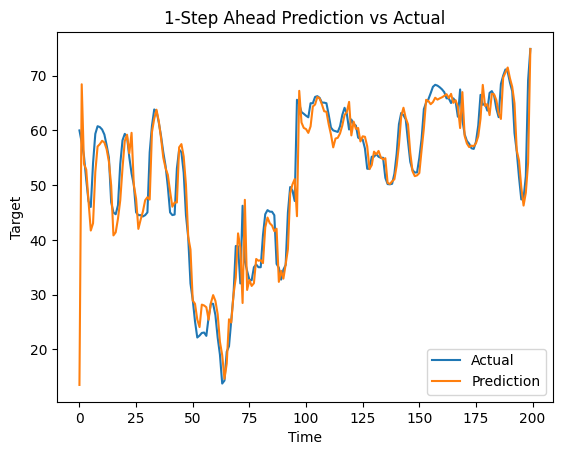

In [104]:
plt.figure()
plt.plot(y_test[:200], label="Actual")
plt.plot(y_pred_1step[:200], label="Prediction")
plt.title("1-Step Ahead Prediction vs Actual")
plt.xlabel("Time")
plt.ylabel("Target")
plt.legend()
plt.show()

The 1-step ahead prediction closely follows the actual electricity price series, capturing both short-term fluctuations and larger trend changes with high accuracy. Small deviations mainly appear around sharp peaks and sudden drops, which is expected since abrupt changes are harder to predict from past values alone.

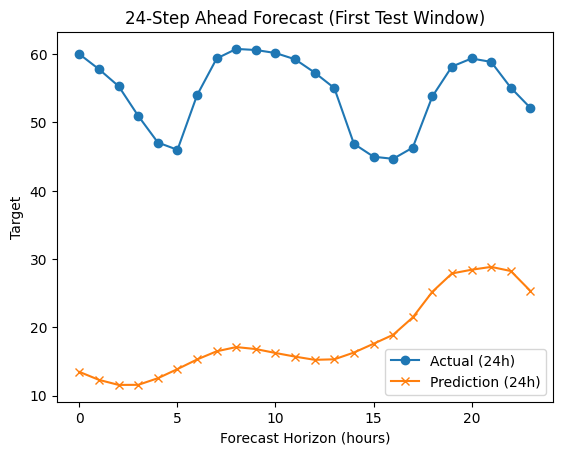

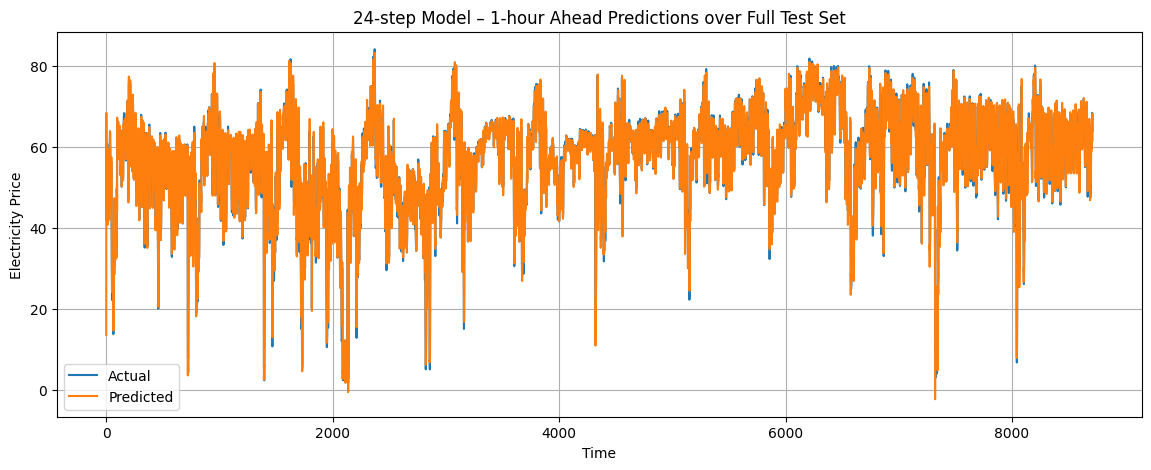

In [105]:
plt.figure()
plt.plot(y_test_24[0], marker="o", label="Actual (24h)")
plt.plot(y_pred_24step[0], marker="x", label="Prediction (24h)")
plt.title("24-Step Ahead Forecast (First Test Window)")
plt.xlabel("Forecast Horizon (hours)")
plt.ylabel("Target")
plt.legend()
plt.show()

y_test_full = y_test_24[:, 0]
y_pred_full = y_pred_24step[:, 0]

plt.figure(figsize=(14, 5))
plt.plot(y_test_full, label="Actual")
plt.plot(y_pred_full, label="Predicted")
plt.title("24-step Model – 1-hour Ahead Predictions over Full Test Set")
plt.xlabel("Time")
plt.ylabel("Electricity Price")
plt.legend()
plt.grid(True)
plt.show()

The first plot (24-step ahead, first test window) shows poor accuracy because it is a direct multi-output forecast, where the model must predict all 24 future hours at once; errors accumulate quickly and the model struggles to capture the full daily amplitude and level.

The second plot (full test set) looks much better because it effectively evaluates many overlapping short-horizon predictions, where the model mainly follows the overall pattern and seasonality, even though individual point-wise errors are still present.

### 4.3 Deep Learning Models

TODO

---
## 6. Conclusions and Recommendations

### 6.1 Summary of Findings


### 6.2 Best Model Selection

### 6.3 Future Work


### 6.4 Lessons Learned


---

## Project Notes and Team Collaboration

### Team Members

- Julia Kardasz 1250264
- Mateusz Nowak 1250296
- Emilia Pawlowska 1250230